# 『ガウス過程と機械学習』3章の図に関する実装

## 図3.1の実装
基底関数を動径基底関数
$$
\phi_h (x) = \exp{\{-\frac{(x-\mu_h)^2}{\sigma^2}\}}\ , \ (h = -H , \frac{1}{H} - H , ... , - \frac{1}{H}+H , H)
$$

としたときの回帰問題をサンプルとして提示します．


In [51]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [52]:
plt.style.available # スタイル確認

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [53]:
x = np.arange(-4 , 5 , 0.1 )
x

array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
       -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
       -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
       -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
       -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
       -2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        3.55271368e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  

In [54]:
mu = np.arange(-3 , 5 , 1 )
mu

array([-3, -2, -1,  0,  1,  2,  3,  4])

In [55]:
sigma = 1

In [56]:
omega = np.array([-0.48 , -0.64 , 0.41 , 0.28 , 0.57 , 0.50 , -0.26 , 0.60])
omega

array([-0.48, -0.64,  0.41,  0.28,  0.57,  0.5 , -0.26,  0.6 ])

In [57]:
def radial_basis_function(x , mu_h , sigma):
    phi = np.exp(- (x - mu_h / sigma)**2)
    return phi

In [58]:
def radial_basis_function_vecteor(x , mu , sigma):# xとmuは同じ次元のベクトル
    phi_vector = []
    length = len(mu)
    # ベクトルの各要素に対して基底関数を計算
    for i in range(length) :
        phi_vector.append(radial_basis_function(x , mu[i] , sigma))
    return phi_vector

In [59]:
def regression_function(x , omega , mu , sigma):
    phi_vector = radial_basis_function_vecteor(x , mu , sigma)
    y = np.dot(omega , phi_vector)
    return y
x1 = np.arange(-2, 2, 0.05) # x1点として[-2, 2]まで0.05刻みでサンプル
x2 = np.arange(-2, 2, 0.05)  # x2点として[-2, 2]まで0.05刻みでサンプル
x1, x2 = np.meshgrid(x1, x2)  # 上述のサンプリング点(x1,x2)を使ったメッシュ生成


In [60]:
phi_vector = radial_basis_function_vecteor(x , mu , sigma)
phi_vector

[array([3.67879441e-01, 4.44858066e-01, 5.27292424e-01, 6.12626394e-01,
        6.97676326e-01, 7.78800783e-01, 8.52143789e-01, 9.13931185e-01,
        9.60789439e-01, 9.90049834e-01, 1.00000000e+00, 9.90049834e-01,
        9.60789439e-01, 9.13931185e-01, 8.52143789e-01, 7.78800783e-01,
        6.97676326e-01, 6.12626394e-01, 5.27292424e-01, 4.44858066e-01,
        3.67879441e-01, 2.98197279e-01, 2.36927759e-01, 1.84519524e-01,
        1.40858421e-01, 1.05399225e-01, 7.73047404e-02, 5.55762126e-02,
        3.91638951e-02, 2.70518469e-02, 1.83156389e-02, 1.21551783e-02,
        7.90705405e-03, 5.04176026e-03, 3.15111160e-03, 1.93045414e-03,
        1.15922917e-03, 6.82328053e-04, 3.93669041e-04, 2.22629857e-04,
        1.23409804e-04, 6.70548243e-05, 3.57128496e-05, 1.86437423e-05,
        9.54016287e-06, 4.78511739e-06, 2.35257520e-06, 1.13372714e-06,
        5.35534780e-07, 2.47959602e-07, 1.12535175e-07, 5.00621802e-08,
        2.18295780e-08, 9.33028757e-09, 3.90893843e-09, 1.605228

In [61]:
y = regression_function(x , omega , mu , sigma)
y

array([-0.18825351, -0.23075371, -0.2780037 , -0.32934937, -0.38388373,
       -0.44048705, -0.49788378, -0.55470712, -0.60956079, -0.66106775,
       -0.70789881, -0.74877935, -0.78247835, -0.80778992, -0.823521  ,
       -0.82849994, -0.82161696, -0.8019013 , -0.76863088, -0.72146118,
       -0.66055278, -0.58667324, -0.50125012, -0.40635768, -0.30462951,
       -0.19910127, -0.09299891,  0.0105029 ,  0.10852249,  0.19868359,
        0.27927348,  0.34933075,  0.40865651,  0.45775395,  0.49770911,
        0.53003196,  0.55647847,  0.57887343,  0.59895016,  0.61821835,
        0.63786641,  0.65870062,  0.68112036,  0.70512649,  0.73035881,
        0.75615713,  0.78163888,  0.80578527,  0.82752632,  0.84581585,
        0.85968832,  0.86829346,  0.87090858,  0.86693421,  0.85588263,
        0.83737152,  0.81113398,  0.77705299,  0.73522137,  0.68602147,
        0.63021091,  0.56899629,  0.50407445,  0.43762392,  0.37223441,
        0.31077177,  0.25618508,  0.21127276,  0.17843148,  0.15

Text(0.5, 1.0, 'fig3.1')

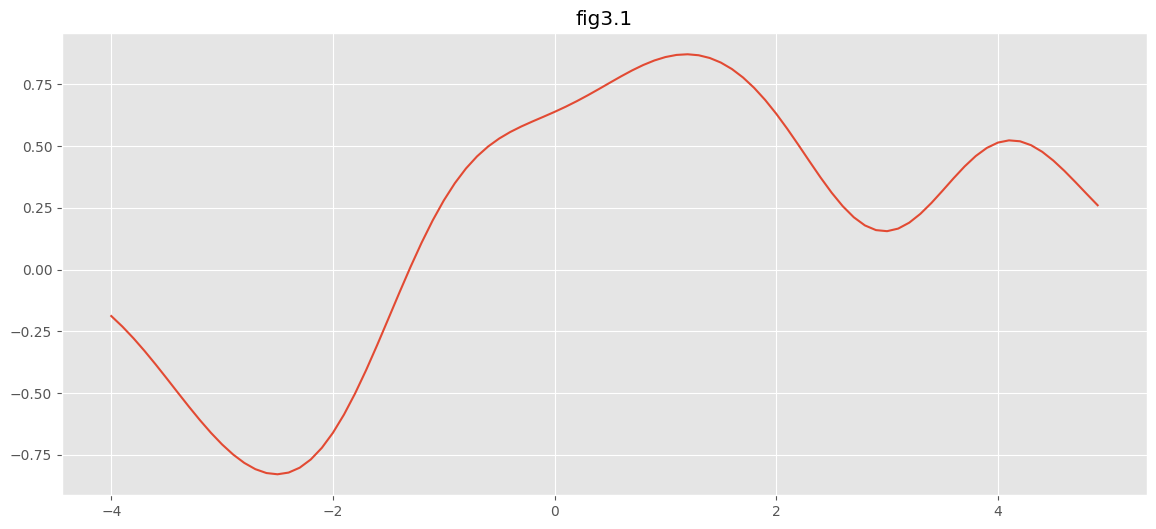

In [62]:
fig , ax = plt.subplots(figsize=(14, 6))

ax.plot(x , y , label = "regression_function")
ax.set_title("fig3.1")

## 図3.4の実装
ガウス過程の概念図を実装します．

ただし，今回カーネルは以下のように定義します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

In [63]:
Theta_1 , Theta_2 , Theta_3 = 10 , 1 , 0.1

In [64]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

In [65]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K

In [66]:
kai = np.arange(-4 , 5 , 0.1 )

In [67]:
K = compute_kernel(kai , Theta_1 , Theta_2 , Theta_3)

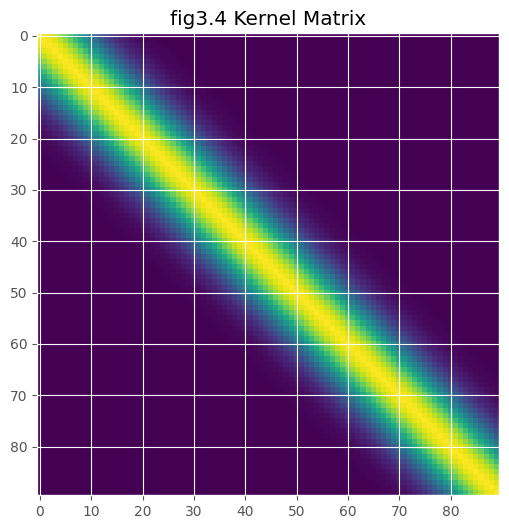

In [68]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
ax.set_title("fig3.4 Kernel Matrix")
plt.show()

# 図3.11の実装

先程定義したカーネルに対して図3.11のようなサンプルを生成します．

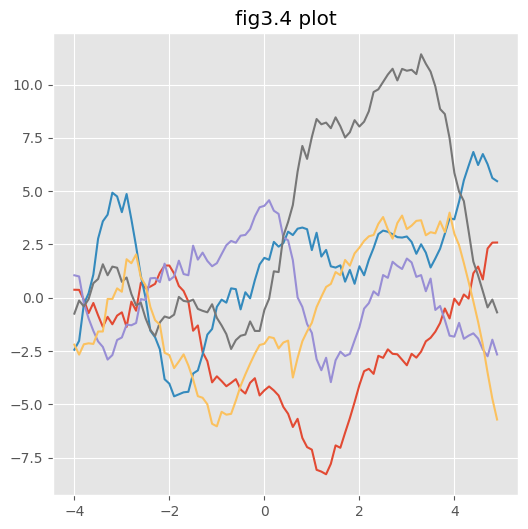

In [69]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.4 plot")
plt.show()

### 線形カーネル（清水）
$$
k(x , x^{'}) = \theta_1 x x^{'}
$$

In [70]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return p * np.dot(x, x_prime)

In [71]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [72]:
kai = np.arange(-4 , 5 , 0.1 )

In [73]:
K = compute_kernel(kai , Theta_1)

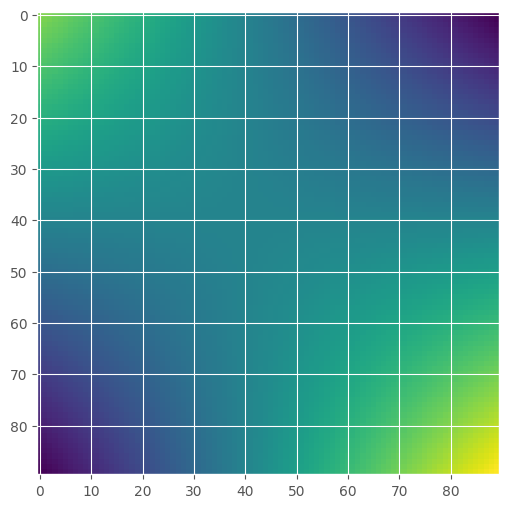

In [74]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

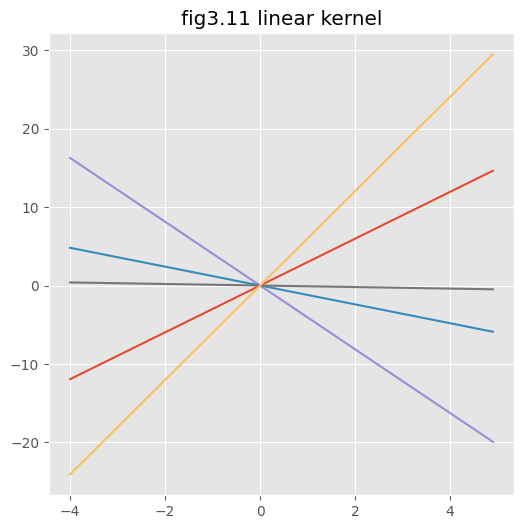

In [75]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.11 linear kernel")
plt.show()

### 指数カーネル（川本）
$$
k(x , x^{'}) = \exp{\left( - \frac{|x - x^{'}|}{\theta} \right)}
$$

これはOUノイズに対応するもの．

#### ReMark:OUノイズ
OUノイズは，調和振動子ポテンシャルに従うブラウン運動である．

チャップマン・コロモゴロフ方程式(ガーディナー3.8.4節)
$$
\frac{\partial p(x , t)}{\partial t} =  \frac{\partial (k x p(x , t))}{\partial x} +\frac{D}{2} \frac{\partial^2 p(x , t)}{\partial x^2}
$$

確率微分方程式(ガーディナー4.5.4節)
$$
dx = -kx\ dt+ \sqrt{D}\ dW(t)
$$

積分方程式(ガーディナー4.5.4節)
$$
x(t) = x(0) \exp{\{-kt\}} + \sqrt{D} \int_0^t \exp{\{-k(t-s)\}} dW(s)
$$

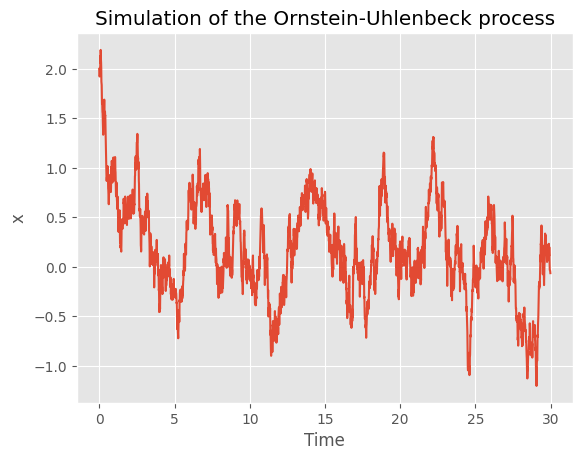

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 0.5  # 熱浴の温度定数 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 2.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列
x = np.zeros(N)  # xの値の配列
x[0] = x0

# シミュレーション
for i in range(N-1):
    dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
    x[i+1] = x[i] - k * x[i] * dt + np.sqrt(D) * dW
    t[i+1] = t[i] + dt

# グラフのプロット
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulation of the Ornstein-Uhlenbeck process')
plt.grid(True)
plt.show()


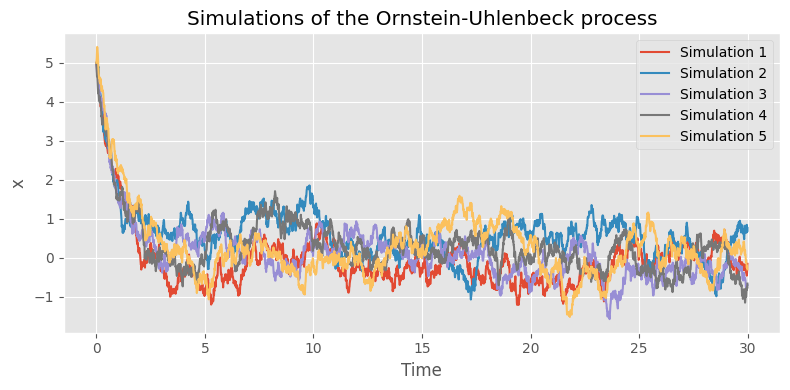

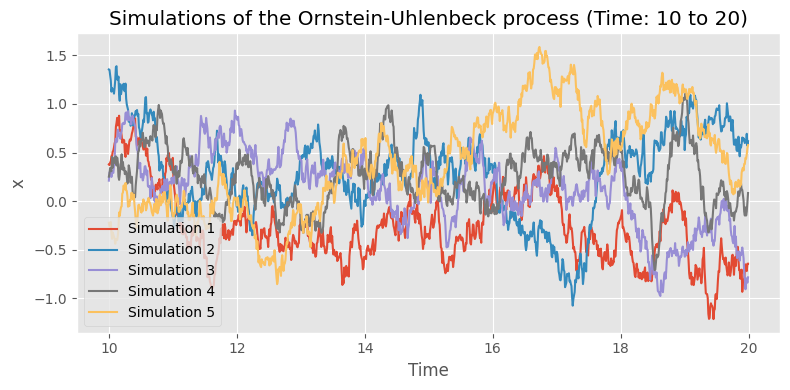

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # 定数 k
D = 0.5  # ノイズの強度 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 5.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 5  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 元の0から観測時間までのプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t, simulations[i], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 時間範囲の指定
t_start = 10.0
t_end = 20.0
start_index = int(t_start / dt)
end_index = int(t_end / dt)

# 時間指定したプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t[start_index:end_index], simulations[i, start_index:end_index], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process (Time: 10 to 20)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


理論的な期待値
$$
E[x(t)] = x_0 \exp{\{-kt\}}
$$

理論的な分散
$$
Var[x(t)] = \frac{D}{2k} (1 - \exp{\{-2kt\}})
$$

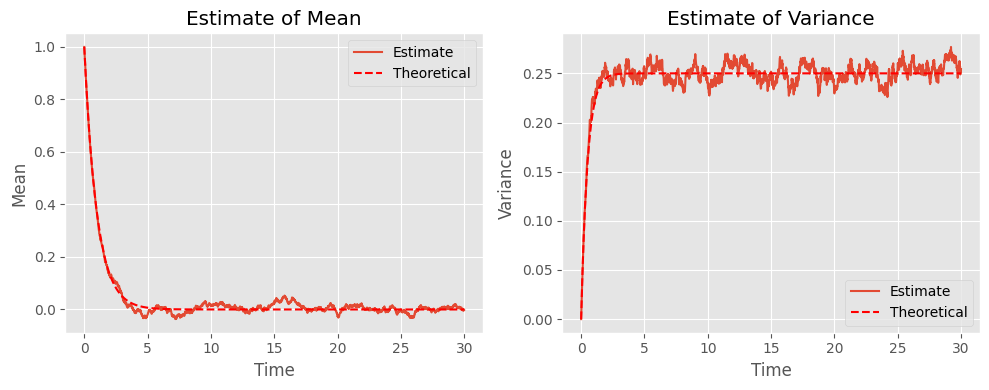

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 0.5  # 熱浴の温度定数 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 1.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 1000  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 期待値と分散の推定値の計算
mean_estimates = np.mean(simulations, axis=0)
variance_estimates = np.var(simulations, axis=0)

# 理論的な期待値と分散の計算
x_theoretical = x0 * np.exp(-k * t)
mean_theoretical = x0 * np.exp(-k * t)
variance_theoretical = (D / (2 * k)) * (1 - np.exp(-2 * k * t))

# グラフのプロット
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(t, mean_estimates, label='Estimate')
plt.plot(t, mean_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.title('Estimate of Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, variance_estimates, label='Estimate')
plt.plot(t, variance_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Estimate of Variance')
plt.legend()

plt.tight_layout()
plt.show()

#### OUノイズの定常状態
OUノイズの定常分布は，以下のようになる．
$$
p_s(x) = \sqrt{ \frac{k}{\pi D} } \exp{\left( - \frac{ k x^2}{D} \right)}
$$

また，定常自己相関関数は以下のようになる．
$$
C(\tau) = \frac{D}{2k} \exp{\{-k|\tau|\}}
$$

この自己相関関数が，指数カーネルと一致します．

Remark:指数カーネル
$$
k(x , x^{'}) = \exp{\left( - \frac{|x - x^{'}|}{\theta} \right)}
$$

話は指数カーネルに戻ります．

In [79]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return np.exp(-1 * np.abs(x - x_prime) / p)

In [80]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [81]:
kai = np.arange(0 , 10 , 0.01 )

In [82]:
K = compute_kernel(kai , 1)

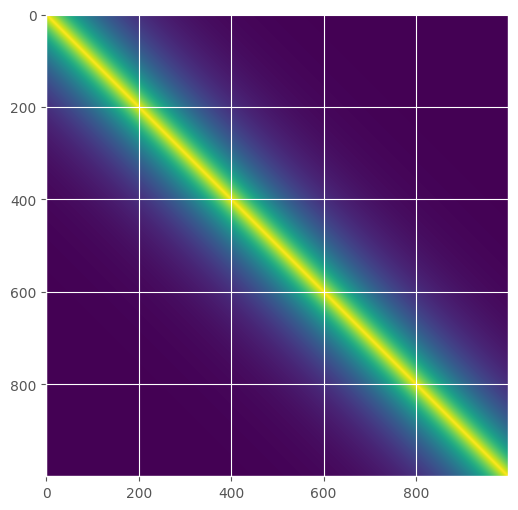

In [83]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

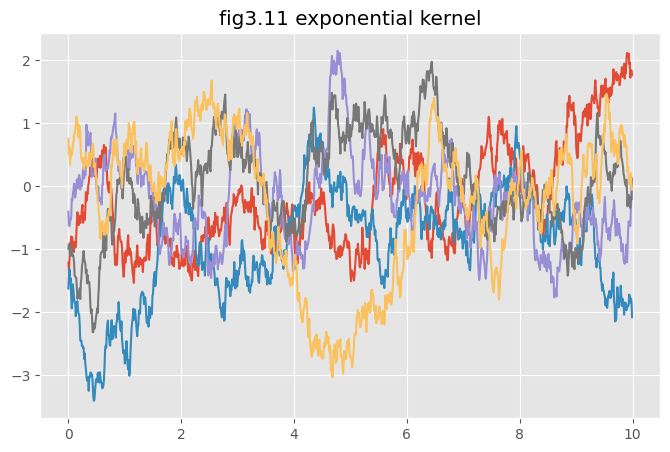

In [84]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 5)

fig, ax = plt.subplots(figsize=(8, 5) )
ax.plot(kai, y.T)
ax.set_title("fig3.11 exponential kernel")
plt.show()

### 周期カーネル（原，高森）
$$
k(x , x^{'}) = \exp{\left( \theta_1 \cos(|x-x^{\prime}| / \theta_2)\right)}
$$

In [85]:
# カーネル関数を定義
def kernel(x, x_prime, p):
    return np.exp(p * np.cos(x - x_prime) / p)

In [86]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1)
    return K

In [87]:
kai = np.arange(-20 , 20 , 0.1 )

In [88]:
K = compute_kernel(kai , Theta_1)

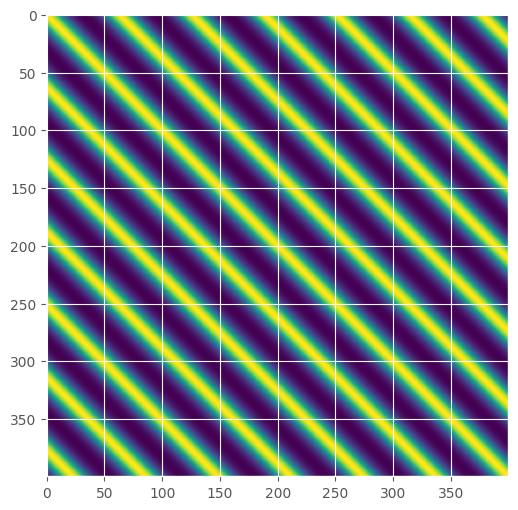

In [89]:
fig, ax = plt.subplots(figsize=(6, 6) )
im = ax.imshow(K)
plt.show()

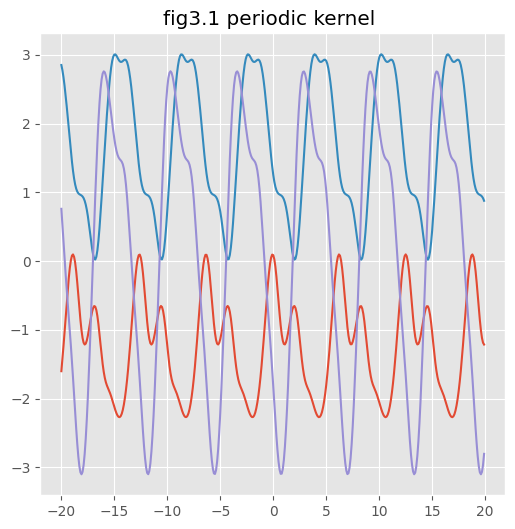

In [90]:
mu = 0 * kai
y = np.random.multivariate_normal(mu, K , 3)

fig, ax = plt.subplots(figsize=(6, 6) )
ax.plot(kai, y.T)
ax.set_title("fig3.1 periodic kernel ")
plt.show()

## 図3.16の実装
ガウス過程回帰の予測結果に関する図の再現

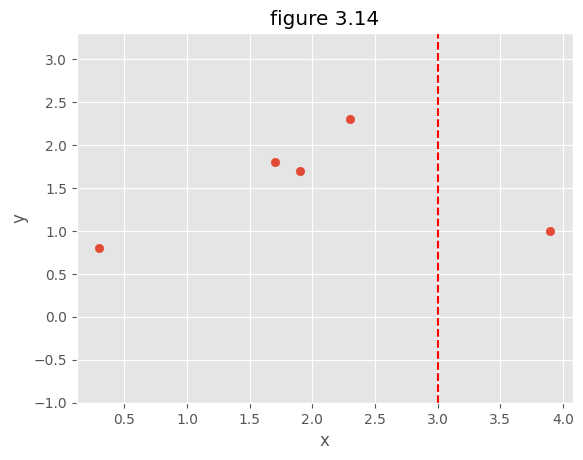

In [91]:
x = np.array([1.7 , 3.9, 1.9 , 0.3 , 2.3])
y = np.array([1.8 , 1.0 , 1.7 , 0.8 , 2.3])

plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1, max(max(y), abs(min(y))) + 1)
plt.axvline(x=3.0, linestyle='dashed', color='red')
plt.title('figure 3.14')
plt.show()

教科書P84の公式3.8より$\vec{y}^{*}$の予測分布は
$$
p(y^{*} | \vec{x}^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$
ただし，グラム行列$K$は
$$
K^{(train) } = 
\begin{pmatrix}
k(x_1 , x_1) & k(x_1,x_2) & k(x_1,x_3) & ・・・ & k(x_1,x_{N_{train}}) \\
k(x_2,x_1)  & k(x_2,x_2) & k(x_2,x_3) & ・・・ & k(x_2,x_{N_{train}})  \\
k(x_3,x_1)  & k(x_3,x_2) & k(x_3,x_3) & ・・・ & k(x_3,x_{N_{train}}) \\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
k(x_{N_{train} }, x_1) & k(x_{N_{train}} , x_2) & k(x_{N_{train}} , x_3) & ・・・ & k(x_{N_{train}} , x_{N_{train}}) \\
\end{pmatrix}
$$

また，$\textbf{k}_*$は，以下のようなベクトルになります．
$$
\textbf{k}_* = (k(x^*,x_1) , k(x^*,x_2) , k(x^*,x_3) ,.... ,k(x^*,x_{N_{train}}))\top
$$

図3.16の予測では，以下のカーネルでやっています．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

In [92]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

In [93]:
# グラム行列の計算
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K

In [94]:
# パラメータ値
Theta_1 = 1
Theta_2 = 0.25
Theta_3 = 0.01


# カーネル計算
K = compute_kernel(x , Theta_1 , Theta_2 , Theta_3)

In [95]:
# K^{-1} * y を計算する関数
def Expected_train(K , y):
    yy = np.dot(np.linalg.inv(K), y) # np.linalg.invは逆行列
    return yy

In [96]:
x_asterisk  = np.arange(0 , 5 , 0.2 ) 

In [97]:
# 予測分布の期待値，分散の計算
def predict(X_train , X_test , Theta_1 , Theta_2 , Theta_3) :
    # 平均
    mu = []
    # 分散
    var = []

    train_length = len(X_train)
    test_length = len(X_test)
    for x_test in range(test_length):

    # テストデータとトレーニングデータ間のカーネル行列の下地を準備
        k = np.zeros(train_length)
        for x in range(train_length):
            
            # 訓練データとテストデータのカーネル
            k[x] = kernel(X_train[x], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.68)式
            
            #テストデータ同士のカーネル
        s = kernel(X_test[x_test], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.69)式

    # K^{-1} * y を計算
        yy = Expected_train(K , y)

    # 内積はドットで計算して, 平均値の配列に追加
        mu.append(np.dot(k, yy)) # (3.74)式の期待値
    
    # 先に『k * K^-1』の部分を(内積なのでドットで)計算
        kK_ = np.dot(k, np.linalg.inv(K)) 
    
    # 後半部分との内積をドットで計算して, 分散の配列に追加
        var.append(s - np.dot(kK_, k.T)) # (3.74)式の分散
    
    return mu , var

In [98]:
mu , var = predict(x , x_asterisk , Theta_1 , Theta_2 , Theta_3) 
mu , var

([0.5518123932642457,
  0.7602568622328213,
  0.7633773217851282,
  0.5748682736903542,
  0.3999094150050823,
  0.477573765397783,
  0.9014009208751701,
  1.4652756111353635,
  1.763894615973087,
  1.7303233782239973,
  1.804757883070847,
  2.150072235732798,
  2.2555386739413184,
  1.757706445439899,
  0.9829152349452539,
  0.42431437134603345,
  0.2486787913616872,
  0.3864886799602384,
  0.693985356128399,
  0.9515309880015745,
  0.9512071216231197,
  0.6906999224015695,
  0.36420009324600044,
  0.13944960276792392,
  0.03877219062971397],
 [0.5280668275518011,
  0.09602319691407957,
  0.09602132109616812,
  0.5278826434083053,
  0.871720929212771,
  0.9432514569815071,
  0.7542510309820818,
  0.3344088933063839,
  0.04910342790622357,
  0.017353006896267953,
  0.029480462122433493,
  0.032091543107534926,
  0.06173913537506648,
  0.4196473053513192,
  0.82104688875777,
  0.9782307666224036,
  0.9878952723495266,
  0.8759018316279739,
  0.5280649164404375,
  0.09602340591426883,
  0

In [99]:
# 予測分布の描画
import numpy as np
import matplotlib.pyplot as plt

# ガウス過程回帰の結果をプロットする関数
def Gaussian_result(X_train, y_train, X_test, mu, var):
    # 分散を標準偏差に変換
    std = np.sqrt(var)

    plt.figure(figsize=(10, 5))
    plt.title('fig 3.16', fontsize=20)
 
    # 元の信号
    plt.plot(X_train, y_train, 'x', color='green', label='Correct signal')
    
    # ガウス過程で求めた平均値を信号化
    plt.plot(X_test, mu, color='blue', label='Mean by Gaussian process')

    plt.axvline(x=3.0, linestyle='dashed', color='red')

    # ガウス過程で求めた標準偏差を範囲化 alphaは透明度
    plt.fill_between(X_test, mu - 2 * std, mu + 2 * std, alpha=0.2, color='blue', label='Standard deviation by Gaussian process')

    plt.legend(fontsize=12)
    plt.show()


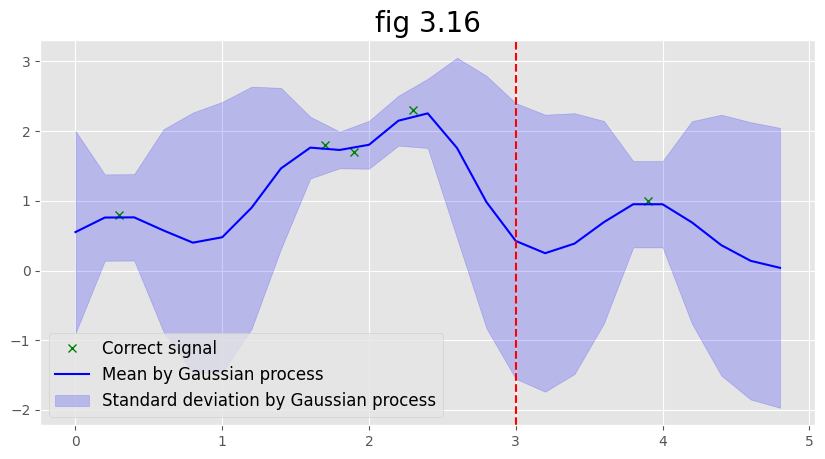

In [100]:
y_astarisk = np.array([1.0])
Gaussian_result(x , y , x_asterisk  , mu , var )